# Pairwise MLP with PU

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- cone around the candidate trackster


## MLP

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from reco.loss import FocalLoss

from reco.datasetPU import TracksterPairsPU
from reco.training import precision_recall_curve, roc_auc


ds_name = "CloseByGamma200PUFull"

# data_root = "data"
# raw_dir = f"/Users/ecuba/data/{ds_name}"

data_root = "/mnt/ceph/users/ecuba/processed"
raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
ds = TracksterPairsPU(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=464,
    radius=10
)

ds.x.shape
ds.processed_file_names

['TracksterPairsPU_CloseByGamma200PUFull_f464_r10_s0.2.pt']

In [4]:
scaler = StandardScaler()
scaler.fit(ds.x)
ds.x = torch.tensor(scaler.transform(ds.x)).type(torch.float)

In [5]:
print(ds.x.shape)

print("Positive:", int((ds.y > 0.8).type(torch.int).sum()))
print("Negative:", int((ds.y < 0.8).type(torch.int).sum()))

torch.Size([175356, 43])
Positive: 6584
Negative: 168772


In [6]:
balance =  float(sum(ds.y > 0.8) / len(ds.y))
print(f"dataset balance: {balance*100:.2f}% / {(1-balance)*100:.2f}%") 

dataset balance: 3.75% / 96.25%


In [25]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=128, shuffle=True)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True)

Train samples: 157821, Test samples: 17535


In [26]:
def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

In [27]:
hdim1 = 256
hdim2 = 256

model = nn.Sequential(
    nn.Linear(ds.x.shape[1], hdim1),
    nn.ReLU(),
    nn.Linear(hdim1, hdim2),
    nn.ReLU(),
    nn.Linear(hdim2, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
)
model = model.to(device)
epochs = 101
model_path = f"models/PairWiseMLP.{hdim1}.{hdim2}.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.pt"

In [28]:
# %%script echo skipping

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)
loss_obj = FocalLoss(alpha=1-balance, gamma=2)

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_auc = roc_auc(model, device, train_dl)
    test_auc = roc_auc(model, device, test_dl)
    scheduler.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train auc: {train_auc:.4f}, test auc: {test_auc:.4f}')

torch.save(model.state_dict(), model_path)

Epoch: 0, loss: 3.2813, train auc: 0.9777, test auc: 0.9722
Epoch: 10, loss: 2.8949, train auc: 0.9833, test auc: 0.9746
Epoch: 20, loss: 2.8628, train auc: 0.9867, test auc: 0.9746
Epoch: 30, loss: 2.7326, train auc: 0.9904, test auc: 0.9717
Epoch: 40, loss: 2.6931, train auc: 0.9923, test auc: 0.9696
Epoch: 50, loss: 2.5948, train auc: 0.9938, test auc: 0.9632
Epoch: 60, loss: 2.5747, train auc: 0.9954, test auc: 0.9632
Epoch: 70, loss: 2.5209, train auc: 0.9963, test auc: 0.9633
Epoch: 80, loss: 2.5183, train auc: 0.9967, test auc: 0.9601
Epoch: 90, loss: 2.4806, train auc: 0.9972, test auc: 0.9627
Epoch: 100, loss: 2.4447, train auc: 0.9976, test auc: 0.9605


In [29]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


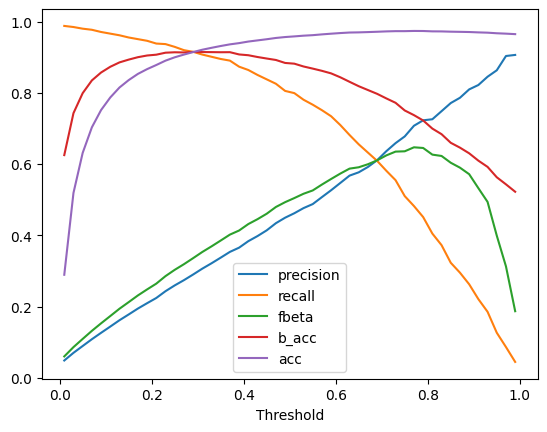

TP: 312, TN: 16759, FP: 129, FN: 335
TH: 0.77 precision: 0.707 recall: 0.482 fbeta: 0.647 b_acc: 0.737 acc: 0.974


In [30]:
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=2)

## Results

- hdim: (256, 128), roc_auc = 0.9956
- hdim: (512, 512), roc_auc = 0.9605 (overfit?) (test auc going down)

In [33]:
roc_auc(model, device, test_dl)

0.9605012055055691